In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

#pip3 install -U scikit-learn go download first!!!

In [3]:
data = pd.read_csv('..\..\..\..\listings.csv') #Importing Dataset
        
data_Numeric = pd.DataFrame(data[["id","host_total_listings_count","zipcode","latitude","longitude","accommodates","bathrooms","bedrooms","beds","price","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights","availability_30","availability_90","availability_365","number_of_reviews","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"]])

for var in data_Numeric:
    if(data_Numeric[var].dtypes == "object"):
        data_Numeric[var] = data_Numeric[var].str.replace(',', '').str.replace('$', '')
        data_Numeric[var] = data_Numeric[var].apply(pd.to_numeric,errors='coerce')

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=4)
data_Numeric_changed = pd.DataFrame(imputer.fit_transform(data_Numeric), columns =data_Numeric.columns)


price_changed = pd.DataFrame(data_Numeric_changed["price"])
reviewscore_changed = pd.DataFrame(data_Numeric_changed["review_scores_rating"])

useless = ["zipcode","latitude","longitude","weekly_price","monthly_price"]
data_Numeric_changed=data_Numeric_changed.drop(axis=1,columns=useless)


data_Numeric_changed.head()

,id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,241032.0,3.0,4.0,1.0,1.0,1.0,85.0,175.0,30.00,2.0,...,346.0,207.0,95.0,10.00,10.0,10.00,10.0,9.0,10.00,4.07
1,953595.0,6.0,4.0,1.0,1.0,1.0,150.0,100.0,40.00,1.0,...,291.0,43.0,96.0,10.00,10.0,10.00,10.0,10.0,10.00,1.48
2,3308979.0,2.0,11.0,4.5,5.0,7.0,975.0,1000.0,300.00,10.0,...,220.0,20.0,97.0,10.00,10.0,10.00,10.0,10.0,10.00,1.15
3,7421966.0,1.0,3.0,1.0,0.0,2.0,100.0,262.5,41.25,1.0,...,143.0,0.0,94.0,9.75,9.5,9.75,9.5,9.0,9.25,2.58
4,278830.0,2.0,6.0,2.0,3.0,3.0,450.0,700.0,125.00,6.0,...,365.0,38.0,92.0,9.00,9.0,10.00,10.0,9.0,9.00,0.89


In [9]:
from sklearn.model_selection import train_test_split

data_Numeric_Train, data_Numeric_test,price_Train, price_test,reviewscore_Train, reviewscore_test = train_test_split(data_Numeric_changed,price_changed,reviewscore_changed,test_size = 0.15)

print("Train Set :", data_Numeric_Train.shape, price_Train.shape, reviewscore_Train.shape)
print("Test Set  :", data_Numeric_test.shape, price_test.shape, reviewscore_test.shape)

Train Set : (3245, 25) (3245, 1) (3245, 1)
Test Set  : (573, 25) (573, 1) (573, 1)


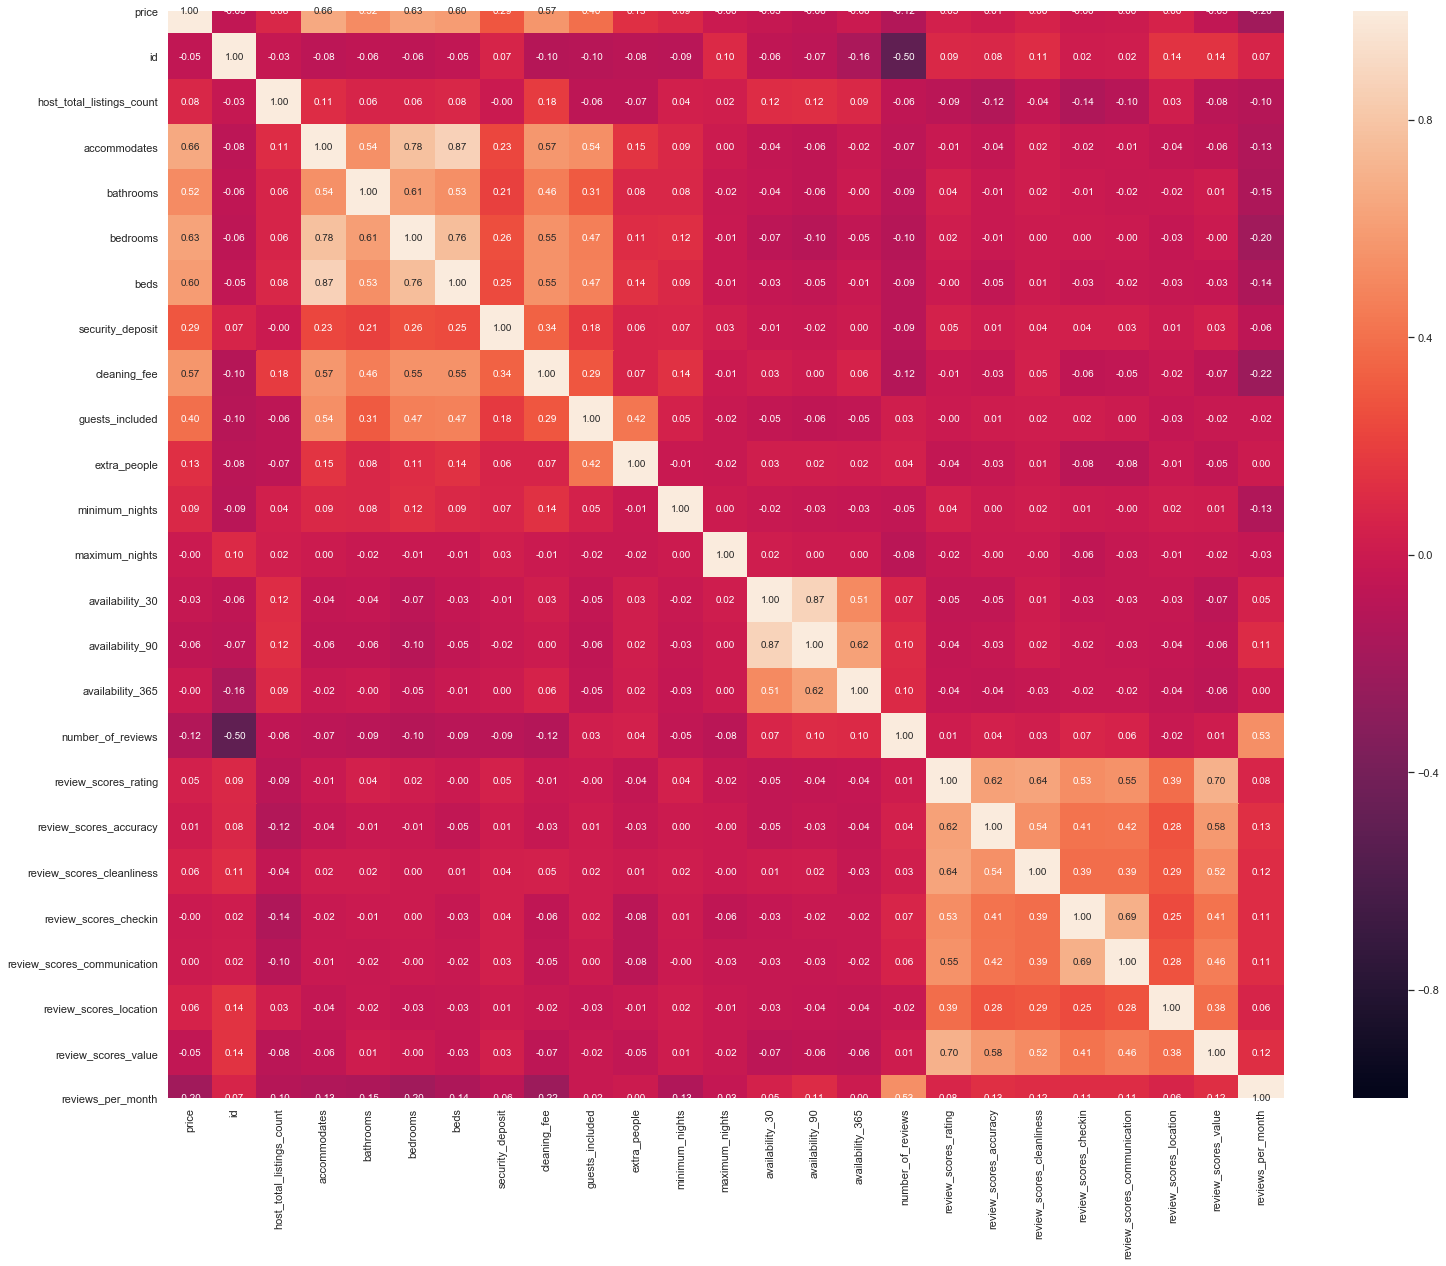

In [10]:
# Correlation between Response and the Predictors
trainDF = pd.concat([price_Train, data_Numeric_Train.reindex(index=data_Numeric_Train.index)], sort = False)

f, axes = plt.subplots(1, 1, figsize=(25, 20))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [11]:
count = 0
highrelation = []
for var in trainDF.corr():
    if(trainDF.corr()['price'][count] > 0.5):
        print("Variables that are Highly Related:",var)
        if(var != "price"):
            highrelation.append(var) 
    count+=1
    
index = 0
Multi_High_Related_Train = {} 
Multi_High_Related_Test = {}

for var in highrelation:
    if(index < len(highrelation)):
        Multi_High_Related_Train[index]={}  
        Multi_High_Related_Test[index]={}
        index+=1

index = 0
index2 = 0
for var in Multi_High_Related_Train:
    for var2 in Multi_High_Related_Train:
        if(index2 < len(Multi_High_Related_Train) and var!=var2):
            Multi_High_Related_Train[index][index2]={}
            Multi_High_Related_Test[index][index2]={}
            index2+=1
    index2=0
    index+=1

index = 0
index2 = 0
index3 = 0

for var in highrelation:
    for var2 in highrelation:
        if(var2!=var and index<len(highrelation)):
            for var3 in highrelation:
                if(var3 != var2 and var3 != var and index2<len(highrelation)):
                    Multi_High_Related_Train[index][index2][index3] = pd.DataFrame(data_Numeric_Train[[var,var2,var3]])
                    Multi_High_Related_Test[index][index2][index3] = pd.DataFrame(data_Numeric_test[[var,var2,var3]])                   
                    index3+=1
            index2+=1
            index3=0
    index+=1
    index2=0

Variables that are Highly Related: price
Variables that are Highly Related: accommodates
Variables that are Highly Related: bathrooms
Variables that are Highly Related: bedrooms
Variables that are Highly Related: beds
Variables that are Highly Related: cleaning_fee


In [12]:
from sklearn.linear_model import LinearRegression

index = 0
linreg = {}

for var in Multi_High_Related_Train:
    if(index < len(Multi_High_Related_Train)):
        linreg[index]={} 
        index+=1
        
index = 0
index2 = 0
for var in Multi_High_Related_Train:
    for var2 in Multi_High_Related_Train[var]:
        if(index2 < len(Multi_High_Related_Train)):
            linreg[index][index2]={}
            index2+=1
    index2=0
    index+=1
    
index = 0
index2 = 0
index3 = 0
for var in Multi_High_Related_Train:
    for var2 in Multi_High_Related_Train[var]:
        for var3 in Multi_High_Related_Train[var][var2]:
            linreg[index][index2][index3] = LinearRegression()
            linreg[index][index2][index3].fit(Multi_High_Related_Train[index][index2][index3], price_Train)
            index3+=1
        index3=0
        index2+=1
    index2=0
    index+=1


In [13]:
index = 0
price_train_pred = {}
price_test_pred = {}

for var in linreg:
    if(index < len(linreg)):
        price_train_pred[index]={} 
        price_test_pred[index]={} 
        index+=1

index = 0
index2 = 0
for var in linreg:
    for var2 in linreg[var]:
        price_train_pred[index][index2] = {}
        price_test_pred[index][index2] = {}
        index2+=1
    index2=0
    index+=1
    
index = 0
index2 = 0
index3 = 0
for var in linreg:
    for var2 in linreg[var]:
        for var2 in linreg[var][var2]:
            price_train_pred[index][index2][index3] = linreg[index][index2][index3].predict(Multi_High_Related_Train[index][index2][index3])
            price_test_pred[index][index2][index3] = linreg[index][index2][index3].predict(Multi_High_Related_Test[index][index2][index3])
            index3+=1
        index3=0
        index2+=1
    index2=0
    index+=1

In [18]:
index = 0
index2 = 0
index3 = 0

# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error


for var in price_train_pred:
    for var2 in price_train_pred[var]:
        for var3 in price_train_pred[var][var2]:
            if(linreg[index][index2][index3].score(Multi_High_Related_Train[index][index2][index3], price_Train)>0.5):
                print("For [",var,"][",var2,"][",var3,"]")
                print(Multi_High_Related_Train[index][index2][index3].columns)
                print("Train Explained Variance (R^2) \t:", linreg[index][index2][index3].score(Multi_High_Related_Train[index][index2][index3], price_Train))
                print("Test Explained Variance (R^2) \t:", linreg[index][index2][index3].score(Multi_High_Related_Test[index][index2][index3], price_test))
                print()
                index3+=1
        index3=0
        index2+=1
    index2=0
    index+=1

For [ 0 ][ 3 ][ 0 ]
Index(['accommodates', 'cleaning_fee', 'bathrooms'], dtype='object')
Train Explained Variance (R^2) 	: 0.507774155467438
Test Explained Variance (R^2) 	: 0.4506926044139406

For [ 0 ][ 3 ][ 1 ]
Index(['accommodates', 'cleaning_fee', 'bedrooms'], dtype='object')
Train Explained Variance (R^2) 	: 0.5068430632049273
Test Explained Variance (R^2) 	: 0.45987657599127857

For [ 1 ][ 3 ][ 0 ]
Index(['bathrooms', 'cleaning_fee', 'accommodates'], dtype='object')
Train Explained Variance (R^2) 	: 0.507774155467438
Test Explained Variance (R^2) 	: 0.45069260441394055

For [ 2 ][ 3 ][ 0 ]
Index(['bedrooms', 'cleaning_fee', 'accommodates'], dtype='object')
Train Explained Variance (R^2) 	: 0.5068430632049273
Test Explained Variance (R^2) 	: 0.45987657599127857

For [ 4 ][ 0 ][ 0 ]
Index(['cleaning_fee', 'accommodates', 'bathrooms'], dtype='object')
Train Explained Variance (R^2) 	: 0.507774155467438
Test Explained Variance (R^2) 	: 0.4506926044139406

For [ 4 ][ 0 ][ 1 ]
Index([